Original implementation of Contrastive-sc method
(https://github.com/ciortanmadalina/contrastive-sc)

In [1]:
import sys
sys.path.append("..")
path= "../"
from sklearn import metrics
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.cluster import KMeans
import seaborn as sns
import copy
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import h5py
from collections import Counter
import pickle
import utils
import os
plt.ion()
plt.show()
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
plt.style.use(f'article.mplstyle')

/opt/conda/lib/python3.7/site-packages/scanpy/api/__init__.py:7: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning,


In [2]:
category = "balanced_data"

## Load run results

In [3]:
all_df = None
for run in range(3):
    for name in [f"{path}output/pickle_results/{category}/{category}_run_{run}.pkl"]:
        df = pd.read_pickle(name)
        df["run"] = run
        if all_df is None:
            all_df = df
        else:
            all_df = pd.concat([all_df, df], ignore_index=True)

all_df= all_df[all_df["nclust"]!=64]

In [4]:
all_df.shape

(48, 13)

# Compute Leiden clustering on representation space

In [5]:
ld2 = pd.DataFrame(columns = ["dataset","Leiden", "run"])
for dataset in all_df["dataset"].unique():
    data_mat = h5py.File(f"{path}R/simulated_data/{category}/{dataset}.h5", "r")

    Y = np.array(data_mat['Y'])
    nclust = np.unique(Y).shape[0]
    for run in range(3):
        if os.path.isfile(f"{path}output/{category}/detailed_results_{dataset}_{run}.pickle"):
            with open(f"{path}output/{category}/detailed_results_{dataset}_{run}.pickle", 'rb') as handle:
                all_res = pickle.load(handle)
            all_features = np.array([all_res['st'][i]["features"] for i in range(len(all_res['st']))])
            for idx in [np.arange(3)]:
                embedding = np.hstack(all_features[idx])
#                 pred = KMeans(n_clusters=nclust, random_state=0).fit_predict(embedding)
#                 ari1 = adjusted_rand_score(Y, pred)

                pred = utils.run_leiden(embedding)
                ari2 = adjusted_rand_score(Y, pred)
                ld2.loc[ld2.shape[0]] = [dataset, ari2, run]
                print(".", end = "")

all_df = pd.merge(all_df, ld2, on = ["dataset", "run"], how = "left")
all_df.shape

................................................

(48, 14)

# Merge with results from competitors

In [7]:
scDeepCluster = pd.read_pickle(f"{path}output/pickle_results/{category}/{category}_scDeepCluster.pkl")
all_df = pd.merge(all_df, scDeepCluster, on = ["dataset", "run"], how = "left")

In [8]:
scDeepCluster = pd.read_pickle(f"{path}output/pickle_results/{category}/{category}_scanpy.pkl")
all_df = pd.merge(all_df, scDeepCluster, on = ["dataset", "run"], how = "left")

In [9]:
sczi = pd.read_pickle(f"{path}output/pickle_results/{category}/{category}_sczi.pkl")
all_df = pd.merge(all_df, sczi, on = ["dataset", "run"], how = "left")
all_df["nclust"] = all_df["nclust"].astype(int)
all_df = all_df[all_df["nclust"]!=64]
all_df["dropout"].unique()

array([0.30715157, 0.07697881, 0.08332657, 0.15805452, 0.16978345,
       0.16202883, 0.36984905, 0.30632595, 0.28812713, 0.39205816,
       0.37864847, 0.16929841, 0.39115226, 0.08290128, 0.07885229,
       0.29512817])

In [10]:
all_df.head()

,dataset,dropout,method1_0,method1_1,method1_2,method2_0,method2_1,method2_2,method3,nclust,original,pca,run,Leiden,scDeepCluster,scanpy,sczi
0,data_1c8,0.307152,0.48716,0.47224,0.55116,0.61923,0.59331,0.63758,0.548230,8,0.06412,0.06826,0,0.627708,0.00358,0.322114,0.35907
1,data_-1c4,0.076979,0.98165,0.97890,0.98411,0.98426,0.98701,0.98200,0.989181,4,0.97883,0.78240,0,0.973981,0.73166,0.950986,0.95403
2,data_-1c8,0.083327,0.95112,0.95480,0.95606,0.96823,0.96726,0.97036,0.970610,8,0.72143,0.33831,0,0.956239,0.12592,0.916769,0.95698
3,data_0c4,0.158055,0.94650,0.93773,0.95331,0.94650,0.94790,0.96338,0.971164,4,0.93033,0.72859,0,0.942001,0.04156,0.840489,0.94888
4,data_0c8,0.169783,0.89347,0.86840,0.89883,0.91289,0.90604,0.91803,0.918084,8,0.44642,0.11944,0,0.907310,0.01299,0.677417,0.88371


In [11]:
ours_basic = [
    'method1_0',
    'method1_1',
    'method1_2',
]
ours_clust = ['method2_0', 'method2_1', 'method2_2']
all_df["dp"] = all_df["dataset"].apply(lambda x: x.split("_")[1].split("c")[0])

dropout_values = all_df.groupby("dp")["dropout"].mean().round(2).to_dict()

all_df["dp"] = all_df["dp"].apply(lambda x: dropout_values[x])

dropout_mid = {v:k for k, v in dropout_values.items()}

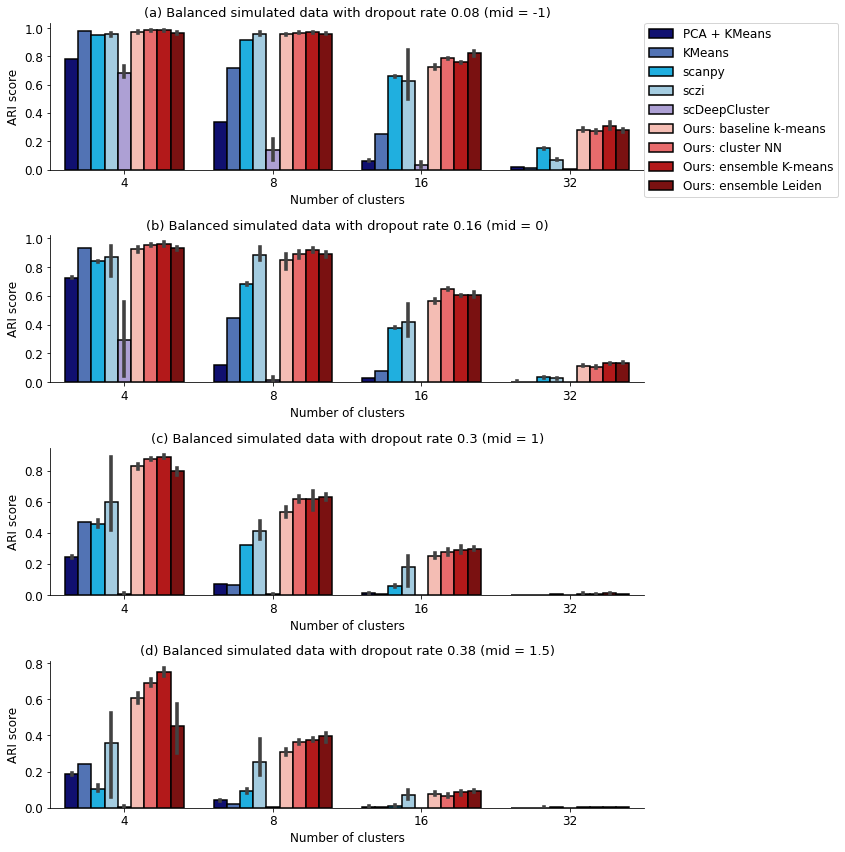

In [12]:
titles = ["(a)", "(b)", "(c)", "(d)",]
clrs = [
    'navy',
    '#416ec5',
    'deepskyblue',
    '#9acfea',
    "#a897dd",
    '#feb6aa',
    '#fd5658',
    '#cc0001',
    "darkred"
]
plt.figure(figsize=(12, 12))
for i, dropout_value in enumerate(sorted(all_df["dp"].unique())):
    df1 = all_df[all_df["dp"] == dropout_value].sort_values(by="nclust")
    df1.drop(["run", "dropout"], axis=1, inplace=True)
    df1 = pd.melt(df1, id_vars=['dataset', 'dp', 'nclust'])

    def rename(x):
        if x in ours_basic:
            return "Ours: baseline k-means"
        if x in ours_clust:
            return "Ours: cluster NN"
        if x == 'method3':
            return "Ours: ensemble K-means"
        if x == 'Leiden':
            return "Ours: ensemble Leiden"
        if x == "pca":
            return "PCA + KMeans"
        if x == "original":
            return "KMeans"
        return x

    def order(x):
        if x == "PCA + KMeans":
            return 0
        if x == "KMeans":
            return 1
        if x == 'Seurat':
            return 3
        if x == 'scanpy':
            return 4
        if x == 'sczi':
            return 5
        if x == "scDeepCluster":
            return 6
        if x == "Ours: baseline k-means":
            return 7
        if x == "Ours: cluster NN":
            return 8
        if x == "Ours: ensemble K-means":
            return 9
        if x == "Ours: ensemble Leiden":
            return 10

        return x

    df1["variable"] = df1["variable"].apply(rename)
    df1["order"] = df1["variable"].apply(order)
    df1 = df1.sort_values(by="order", ascending=True)

    ax = plt.subplot(len(all_df["dp"].unique()), 1, i + 1)
    sns.barplot(data=df1,
                x="nclust",
                y="value",
                hue="variable",
                palette=clrs,
                edgecolor= 'black',
                linewidth=1.5,
                ax=ax)
    plt.xlabel("Number of clusters")
    plt.ylabel("ARI score")
    plt.title(f"{titles[i]} Balanced simulated data with dropout rate {dropout_value}" +
              f" (mid = {dropout_mid[dropout_value]})")
    if i ==0:
        plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)
    else: 
        plt.legend([],[], frameon=False)
    sns.despine()
plt.tight_layout()
plt.savefig(f"{path}diagrams/balanced_by_dropout.pdf", bbox_inches='tight')

In [13]:
df1 = all_df.sort_values(by="nclust")
df1.drop(["run", "dropout"], axis = 1, inplace = True)

df1 =pd.melt(df1, id_vars=['dataset', 'dp',  'nclust'])
df1["variable"]=df1["variable"].apply(rename)
df1["order"]=df1["variable"].apply(order)
df1 = df1.sort_values(by ="order", ascending = True)

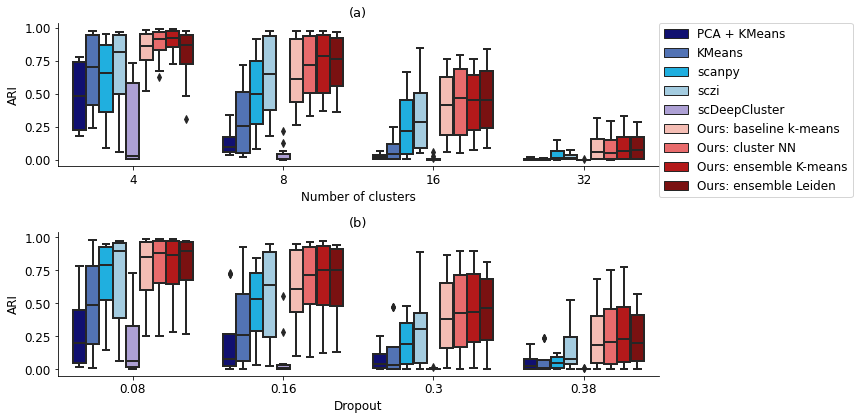

In [14]:
titles = ["(a)", "(b)", "(c)", "(d)",]
plt.figure(figsize=(12, 6))
ax = plt.subplot(211)
plt.title(titles[0])
sns.boxplot(x="nclust",
              y="value",
              hue="variable",
              palette=clrs,
              data=df1,
              ax=ax)
plt.xlabel("Number of clusters")
plt.ylabel("ARI")
plt.legend(bbox_to_anchor=(1, 1), borderaxespad=0.)
sns.despine()


ax = plt.subplot(212)
plt.title(titles[1])
sns.boxplot(
    x="dp",
    y="value",
    hue="variable",
    palette=clrs,
    data=df1.sort_values(by=["dp", "order"]),
    ax=ax)
plt.xlabel("Dropout")
plt.ylabel("ARI")
plt.legend([],[], frameon=False)
sns.despine()
plt.tight_layout()
plt.savefig(f"{path}diagrams/balanced_boxplot.pdf", bbox_inches='tight')

In [16]:
df1.to_pickle(f"{path}output/balanced.pkl")

In [ ]:
#! pip install leidenalg